In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#parameters
experimental_datafile = 'inputs/results_demo.csv'
domain_configfile = 'inputs/borrowing_hydrogen_domain.json'
batch_size = 10

In [98]:
from surrogate_model_functions import plot_3d_model, loo_error
from summit.strategies import TSEMO
from summit.models import GPyModel
from summit.data import solvent_ds, ucb_ds, DataSet
from summit.domain import Domain, DescriptorsVariable,ContinuousVariable
from summit.initial_design import LatinDesigner
# from summit.optimizers import EnumerationOptimizer
# from summit.objective import HV

import GPy
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
#Import experimental results
previous_results = DataSet.read_csv(experimental_datafile)

#Read in solubility data
solubilities = pd.read_csv('inputs/solubilities.csv')
solubilities = solubilities.set_index('cas_number')
solubilities = DataSet.from_df(solubilities)

#Merge data sets
solvent_ds_full = solvent_ds.join(solubilities)
solvent_ds_final = pd.merge(solvent_ds_full, ucb_ds, left_index=True,right_index=True)
print(f"{solvent_ds_final.shape[0]} solvents for optimization")

#Double check that there are no NaNs in the descriptors
values = solvent_ds_final.data_to_numpy()
values = values.astype(np.float64)
check = np.isnan(values)
assert check.all() == False

solvent_ds_final.head(3) #Show first 3 rows of dataset

80 solvents for optimization


,stenutz_name,cosmo_name,chemical_formula,molecular_weight,density,molar_volume,refractive_index,molecular_refractive_power,dielectric_constant,dipole_moment,...,vapour_pressure,henry_constant,sigma_1,sigma_2,sigma_3,sigma_4,sigma_5,solubility,solvent_class,solvent_name
cas_number,,,,,,,,,,,,,,,,,,,,,
56-81-5,"1,2,3-propanetriol",glycerol,C3H8O3,92,1.26,73.1,1.475,20.56,47,2.56,...,0.01,3779.8,1.392,8.3081,2.465,0.5226,3.8766,0.000000,Alcohol,Glycerol
107-06-2,"1,2-dichloroethane","1,2-dichloroethane",C2H4Cl2,99,1.253,79,1.445,21.01,10.36,1.83,...,222.09,2904.4,1.2021,10.4996,0,0,3.5413,-2.004364,Halogenated,"1,2-Dichloroethane (DCE)"
110-71-4,"1,2-dimethoxyethane","1,2-dimethoxyethane",C4H10O2,90,0.869,103.7,1.38,24,7.2,1.71,...,83.42,2260.69,0,12.4399,1.8467,0,1.8566,-2.891152,Ether,Dimethoxyethane (DME)


In [58]:
#Transform to principal componets
num_components = 2
pc = PCA(n_components=num_components)
pcs = pc.fit_transform(solvent_ds_final.standardize())
explained_var = round(pc.explained_variance_ratio_.sum()*100)
expl = f"{explained_var}% of variance is explained by {num_components} principal components."
print(expl)

#Create a new dataset with just the principal components
metadata_df = solvent_ds_final.loc[:, solvent_ds_final.metadata_columns]
pc_df = pd.DataFrame(pcs, columns = [f'PC_{i}' for i in range(num_components)], 
                     index=metadata_df.index)
pc_ds = DataSet.from_df(pc_df)
solvent_ds_pcs = pd.concat([metadata_df, pc_ds], axis=1)

59.0% of variance is explained by 2 principal components.


In [59]:
#Set up optimization domain
domain = Domain()
domain += DescriptorsVariable(name='solvent',
                             description='solvent for the borrowing hydrogen reaction',
                             ds=solvent_ds_pcs)
domain += ContinuousVariable(name='yield',
                             description='relative yield to triphenylphosphine oxide determined by LCMS',
                             bounds=[0, 100],
                             is_output=True)
domain += ContinuousVariable(name='enantiomeric_excess',
                             description='enantiomeric excess determined by ratio of LCMS peaks',
                             bounds=[0, 100],
                             is_output=True)
domain

Name,Type,Description,Values
solvent,"descriptors, input",solvent for the borrowing hydrogen reaction,80 examples of 2 descriptors
yield,"continuous, output",relative yield to triphenylphosphine oxide determined by LCMS,"[0,100]"
enantiomeric_excess,"continuous, output",enantiomeric excess determined by ratio of LCMS peaks,"[0,100]"


In [162]:
#Run the optimization
input_dim = domain.num_continuous_dimensions() +domain.num_discrete_variables()
kernels = [GPy.kern.Matern52(input_dim = input_dim, ARD=True)
           for _ in range(2)]
models = [GPyModel(kernel=kernels[i]) for i in range(2)]
# tsemo = TSEMO(domain, models, acquisition=HV(), optimizer=EnumerationOptimizer())
tsemo = TSEMO(domain, models)
design = tsemo.generate_experiments(previous_results, batch_size, normalize=True)

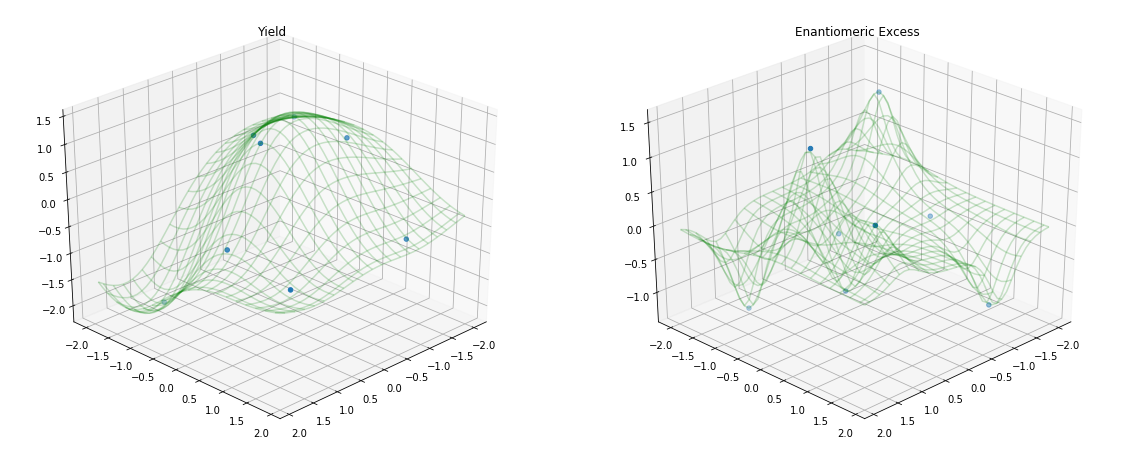

In [163]:
#Plot models
fig = plt.figure(figsize=(20, 8))
axes = [0, 0]
axes[0] = fig.add_subplot(1,2,1, projection='3d')
axes[1] = fig.add_subplot(1,2,2, projection='3d')
fig.subplots_adjust(hspace=0.2, wspace=0.1)
titles = ['Yield', 'Enantiomeric Excess']
for i in range(2):
    axes[i].scatter(tsemo.x[:, 0], tsemo.x[:, 1], tsemo.y[:, i])
    plot_3d_model(axes[i], models[i]._model)
    axes[i].view_init(30,45)
    axes[i].set_title(titles[i])

In [165]:
errors = [loo_error(tsemo.x, np.atleast_2d(tsemo.y[:, i]).T)
          for i in range(2)]
errors = [round(error*100, 1) for error in errors]
print(f"Yield model leave-one-out cross-validation error: {errors[0]}%")
print(f"Enantiomeric Excess model leave-one-out cross-validation error: {errors[1]}%")

Yield model leave-one-out cross-validation error: 27.1%
Enantiomeric Excess model leave-one-out cross-validation error: 41.9%


In [ ]:
#Save design for next experiment(s) and model hyperparameters to disk                                     
next_batch_num = previous_results['batch_number'].max() + 1
design.insert(0, 'batch_number', np.ones(design.shape[0])*next_batch_num, type='METADATA')
design.to_csv(f'outputs/batch_{next_batch_num}.csv')
tsemo.save_params(f'outputs/{batch}')